In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'jaehoon00' # username
os.environ['KAGGLE_KEY'] = 'a62695e809853123499ba86b856655a8' # key

# **인텔 풍경사진 데이터**

```{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }```

https://www.kaggle.com/puneet6060/intel-image-classification

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip

100% 345M/346M [00:15<00:00, 29.3MB/s]
100% 346M/346M [00:15<00:00, 23.8MB/s]


# 패키지 로드

In [5]:
# 패키지 로드
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 이미지 증강기법

In [13]:
# 이미지 증강기법
# flow_from_directory 메서드를 사용하여 직접 데이터 불러오기
train_datagen = ImageDataGenerator(
    rescale=1./255, # 일반화
    rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
    zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
    width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
    height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
    horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_gen = train_datagen.flow_from_directory(
  'seg_train/seg_train',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'seg_test/seg_test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [14]:
from pprint import pprint
pprint(train_gen.class_indices)

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}


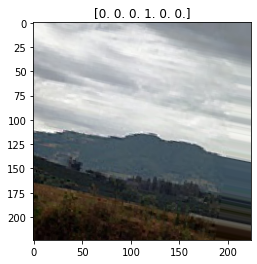

In [18]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])
plt.show()

# 전이학습
https://keras.io/api/applications/resnet/#resnet50-function

In [24]:
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))
base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = input, pooling = 'max')

x = base_model.output
x = Dropout(rate = 0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# 학습
`ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)`

`val_acc`가 높은 1개의 모델(save_best_only)을 model.h5 라는 파일로 저장한다.

https://keras.io/api/callbacks/model_checkpoint/

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data = test_gen,
    epochs = 5,
    callbacks = [
        ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
191/439 [============>.................] - ETA: 2:48 - loss: 1.4352 - acc: 0.6985

KeyboardInterrupt: ignored

# 학습 결과 그래프

NameError: ignored

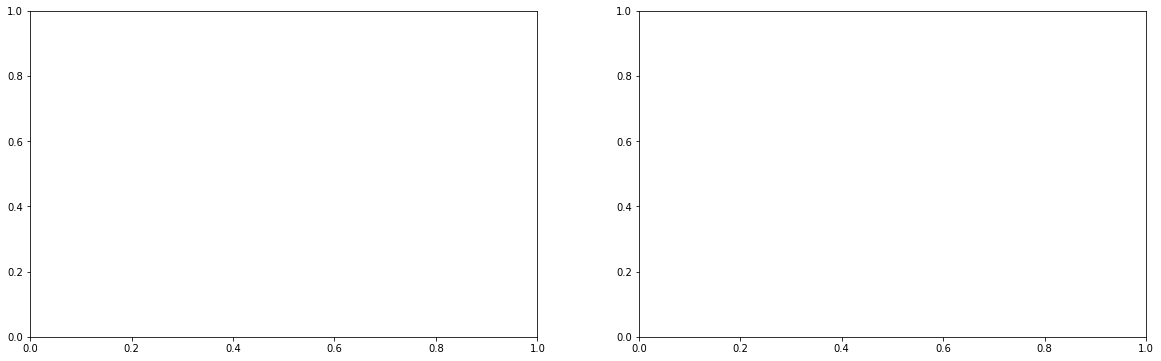

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

# 학습된 모델 로드

In [29]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')
print('Model loaded!!')

OSError: ignored

# 테스트

In [ ]:
test_imgs, test_labels = test_gen.__getitem__(1)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)